In [1]:
import datetime
import Image
import gc
import numpy as np
import os
import random
from scipy import misc
import string
import time
import sys
import sklearn.metrics as skm

# Set some Theano config before initializing
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32,allow_gc=False,openmp=True"
import theano

# MatPlotLib - Setup for Jupyter notebook output
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt

# Our modules
import dwdii_bc_model_helper as bc
import bc_models as models

# And Keras so we can emit the version
import keras

random.seed(20275)
np.set_printoptions(precision=2)

/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scip

In [4]:
# Print some upfront version and config settings
print "Python v" + sys.version
print "Numpy v: " + np.__version__
print "keras v: " + keras.__version__
print "device:", theano.config.device
print "floatX:",  theano.config.floatX
print "mode:", theano.config.mode
print "openmp:", theano.config.openmp
print "allow_gc:", theano.config.allow_gc

Python v2.7.6 (default, Jun 22 2015, 17:58:13) 
[GCC 4.8.2]
Numpy v: 1.8.2
keras v: 1.0.3
device: cpu
floatX: float32
mode: FAST_RUN
openmp: True
allow_gc: False


In [7]:
imagePath = "/root/bc_data/ddsm-png.25"
#imagePath = "/root/bc_data/Data_Thresholded/DDSM"
trainDataPath = "../../data/ddsm_train.csv"

# Simulated training data
trainImagePath = "/root/bc_data/simulated_images"
trainDataPath = "/root/bc_data/simulated_images/simulated_images.csv"

testDataPath = "../../data/ddsm_test.csv"
imgResize = (150, 150)

In [8]:
os.listdir('../../data')

['ddsm_test.csv',
 'ddsm_test.csv.old',
 'ddsm_train.csv',
 'ddsm_train.csv.old',
 'ddsm_val.csv',
 'ddsm_val.csv.old',
 'mias_all.csv']

# Load Training and Test Data

In this section, the training/validation data is loaded. The load_data function pre-balances the data set by removing images from over-represented emotion classes.

### Training Data

In [9]:
metaData, meta2, mCounts = bc.load_training_metadata(trainDataPath, balanceViaRemoval=True, verbose=True)

Raw Balance
----------------
benign 4000
malignant 4000
normal 2000
balanaceViaRemoval.avgE: 3333
balanaceViaRemoval.theshold: 3333.0

After Balancing
----------------
benign 2888
malignant 2888
normal 2000


In [10]:
# Actually load some representative data for model experimentation
maxData = len(metaData)
X_data, Y_data = bc.load_data(trainDataPath, trainImagePath, maxData = maxData, verboseFreq = 50, imgResize=imgResize)
print X_data.shape
print Y_data.shape

Raw Balance
----------------
benign 4000
malignant 4000
normal 2000
balanaceViaRemoval.avgE: 3333
balanaceViaRemoval.theshold: 3333.0

After Balancing
----------------
benign 2888
malignant 2888
normal 2000


dwdii_bc_model_helper.py:181: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  X_data = np.zeros([total, x, y])
dwdii_bc_model_helper.py:182: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_data = np.zeros([total, 1], dtype=np.int8)


0.0000: breast_5400.png
0.0064: breast_1136.png
0.0129: breast_521.png
0.0193: breast_5591.png
0.0257: breast_3845.png
0.0322: breast_8845.png
0.0386: breast_5879.png
0.0450: breast_9108.png
0.0514: breast_7391.png
0.0579: breast_5552.png
0.0643: breast_8334.png
0.0707: breast_2456.png
0.0772: breast_3735.png
0.0836: breast_5167.png
0.0900: breast_1711.png
0.0965: breast_8444.png
0.1029: breast_3103.png
0.1093: breast_2513.png
0.1157: breast_757.png
0.1222: breast_5133.png
0.1286: breast_1395.png
0.1350: breast_8340.png
0.1415: breast_5048.png
0.1479: breast_5812.png
0.1543: breast_3377.png
0.1608: breast_1939.png
0.1672: breast_7640.png
0.1736: breast_9592.png
0.1800: breast_9345.png
0.1865: breast_1087.png
0.1929: breast_515.png
0.1993: breast_7548.png
0.2058: breast_8475.png
0.2122: breast_7526.png
0.2186: breast_998.png
0.2251: breast_5825.png
0.2315: breast_1352.png
0.2379: breast_7971.png
0.2443: breast_6606.png
0.2508: breast_6141.png
0.2572: breast_2729.png
0.2636: breast_5727.

### Load Test Set 

In [12]:
# Actually load some representative data for model experimentation
maxData = len(metaData)
X_test, Y_test = bc.load_data(testDataPath, imagePath, maxData = maxData, verboseFreq = 50, imgResize=imgResize)
print X_test.shape
print Y_test.shape

Raw Balance
----------------
benign 142
malignant 179
normal 658
balanaceViaRemoval.avgE: 326
balanaceViaRemoval.theshold: 326.0

After Balancing
----------------
benign 142
malignant 179
normal 215
0.0000: B_3380_1.RIGHT_MLO.LJPEG.png


dwdii_bc_model_helper.py:181: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  X_data = np.zeros([total, x, y])
dwdii_bc_model_helper.py:182: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_data = np.zeros([total, 1], dtype=np.int8)


0.0064: C_0320_1.LEFT_CC.LJPEG.png
0.0129: B_3022_1.RIGHT_MLO.LJPEG.png
0.0193: A_1041_1.RIGHT_MLO.LJPEG.png
0.0257: B_3382_1.LEFT_CC.LJPEG.png
0.0322: C_0071_1.RIGHT_MLO.LJPEG.png
0.0386: B_3504_1.RIGHT_CC.LJPEG.png
0.0450: A_0498_1.LEFT_CC.LJPEG.png
0.0514: B_3387_1.RIGHT_CC.LJPEG.png
0.0579: C_0326_1.LEFT_MLO.LJPEG.png
0.0643: C_0511_1.LEFT_MLO.LJPEG.png
(536, 150, 150)
(536, 1)


## Training/Test Set Distribution
The following code segment splits the data into training and test data sets. Currently this is a standard 80/20 split for training and test respectively after performing a random shuffle using the unison_shuffled_copies help method.

In [13]:
X_train = X_data
Y_train = Y_data

In [14]:
print X_train.shape
print X_test.shape

print Y_train.shape
print Y_test.shape

(7776, 150, 150)
(536, 150, 150)
(7776, 1)
(536, 1)


In [15]:
import collections
def yDist(y):
    bcCounts = collections.defaultdict(int)
    for a in range(0, y.shape[0]):
        bcCounts[y[a][0]] += 1
    return bcCounts

print "Y_train Dist: " + str(yDist(Y_train))
print "Y_test Dist: " + str(yDist(Y_test))


Y_train Dist: defaultdict(<type 'int'>, {0: 2000, 1: 2888, 2: 2888})
Y_test Dist: defaultdict(<type 'int'>, {0: 215, 1: 142, 2: 179})


## Define and Load Trained Model

In [16]:
# Load the bc array for our count in the model definition
bcTypes = bc.bcNumerics()
print bcTypes
print len(bcTypes)

{'benign': 1, 'malignant': 2, 'normal': 0}
3


In [17]:
# Construct the model using our help function
model = models.bc_model_v01(len(bcTypes), verbose=True, 
                                        input_shape=(1,X_train.shape[1],X_train.shape[2]))

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_1 (Convolution2D)    (None, 32, 143, 143)2080        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 32, 143, 143)0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)      (None, 32, 71, 71)  0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 32, 67, 67)  25632       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

## Training the Model

The following code segment trains the model using the run_network helper function. 

In [18]:
loadWeights = False
weightsFileName = "dwdii-bc-v01-simulated150-7776-20170424.hdf5"
if loadWeights:
    model.load_weights('weights/' + weightsFileName)

In [19]:
# Reshape to the appropriate shape for the CNN input
testX = X_test.reshape(X_test.shape[0], 1, X_test.shape[1],X_test.shape[2])
trainX = X_train.reshape(X_train.shape[0], 1, X_train.shape[1],X_train.shape[2])

In [20]:
print "Training start: " + str(datetime.datetime.now())
m, h = models.run_network([trainX, testX, Y_train, Y_test], model, batch=50, epochs=30, verbosity=1)

Training start: 2017-04-25 02:28:32.549664
(7776, 3)
(536, 3)
Training model...
Train on 7776 samples, validate on 536 samples
Epoch 1/30
7776/7776 [==============================] - 1308s - loss: 0.9584 - acc: 0.5096 - val_loss: 1.1075 - val_acc: 0.4198
Epoch 2/30
7776/7776 [==============================] - 1255s - loss: 0.7801 - acc: 0.6559 - val_loss: 1.1956 - val_acc: 0.4254
Epoch 3/30
7776/7776 [==============================] - 1211s - loss: 0.7614 - acc: 0.6439 - val_loss: 1.3043 - val_acc: 0.4254
Epoch 4/30
7776/7776 [==============================] - 1216s - loss: 0.7168 - acc: 0.6726 - val_loss: 1.3000 - val_acc: 0.4384
Epoch 5/30
7776/7776 [==============================] - 1234s - loss: 0.6926 - acc: 0.6795 - val_loss: 1.4389 - val_acc: 0.3713
Epoch 6/30
7776/7776 [==============================] - 1229s - loss: 0.6295 - acc: 0.7077 - val_loss: 1.4794 - val_acc: 0.4571
Epoch 7/30
7776/7776 [==============================] - 1225s - loss: 0.6665 - acc: 0.6950 - val_loss: 1.

In [17]:
model.save_weights('weights/' + weightsFileName, overwrite=True)

### Experiment Results

#### Raw DDSM Images

Initial results based on "normal" being masked as "benign":
* bc_model_v0 (150x150, 800/200): 182s - loss: 0.0560 - acc: 0.9813 - val_loss: 1.9918 - val_acc: 0.6800
* bc_model_v0 (150x150, 2000/500): 473s - loss: 0.0288 - acc: 0.9925 - val_loss: 1.4040 - val_acc: 0.7260
   * somewhat balanced, Y_train Dist {0: 1223, 1: 777}, Y_test Dist: {0: 321, 1: 179}

Revised with "normal", "benign" and "malignant" labeled seperately:
* bc_model_v0 (150x150, 1311/328): 298s - loss: 0.0411 - acc: 0.9786 - val_loss: 1.3713 - val_acc: 0.6616

After creating fixed "train", "test" and "validate" data sets, using "train" and "test" as well as including the DDSM Benign cases:
* bc_model_v0 (150x150, 1554/363, 03.27.2017): 264s - loss: 0.0512 - acc: 0.9730 - val_loss: 1.3120 - val_acc: 0.6116
* bc_model_v0 (150x150, 2155/539, 04.02.2017): 362s - loss: 0.0600 - acc: 0.9763 - val_loss: 1.5315 - val_acc: 0.4805

bc_model_v01 - categorical_crossentropy
* bc_model_v01 (150x150, 2155/539, 04.03.2017): 361s - loss: 0.0935 - acc: 0.9800 - val_loss: 2.7872 - val_acc: 0.5065
* bc_model_v01 (150x150, 2132/536, 04.05.2017): 369s - loss: 0.0718 - acc: 0.9794 - val_loss: 2.5604 - val_acc: 0.5243

#### Thresholded Images

Using the "Data_Thresholded" images
* bc_model_v0 (150x150, Thresholded, 661/171, 03.28.2017): 124s - loss: 0.0529 - acc: 0.9743 - val_loss: 1.4331 - val_acc: 0.4971

#### Simulated Images

Using the "simulated_images" images
* bc_model_v01 (150x150, 7776/536, 04.24.2017): 1250s - loss: 0.5543 - acc: 0.7885 - val_loss: 7.1153 - val_acc: 0.4123

In [16]:
resultsValAcc = {}
resultsValAcc["1"] = 0.6800
resultsValAcc["2"] = 0.7260
resultsValAcc["3"] = 0.6616
resultsValAcc["03-27-2017"] = 0.6116
resultsValAcc["04-02-2017"] = 0.4805
resultsValAcc["04-03-2017"] = 0.5065
resultsValAcc["04-05-2017"] = 0.5243
import dwdii_test as dwdii
#cmp = matplotlib.colors.Colormap("Blues")
dwdii.barChart(resultsValAcc, filename="../../figures/daniels_results_valacc.png", title="DDSM Results Acc_Val", yAxisLabel="val_acc %")

<module 'matplotlib.pyplot' from '/usr/lib/pymodules/python2.7/matplotlib/pyplot.pyc'>

### Analyze Predictions with Test Set

In [18]:
predictOutput = model.predict(testX, batch_size=32, verbose=1)

536/536 [==============================] - 26s    


In [19]:
predClass = np.array(predictOutput[0]).argmax()
numBC = bc.numericBC()
numBC[predClass]

'normal'

In [20]:
numBC[Y_test[0][0]]

'normal'

In [21]:
predClasses = []
for i in range(len(predictOutput)):

    arPred = np.array(predictOutput[i])
    predictionProb = arPred.max()
    predictionNdx = arPred.argmax()
    predClassName = numBC[predictionNdx]
    predClasses.append(predictionNdx)

    #print "{0}: {1} ({2})".format(i, predClassName, predictionProb)

### Confusion Matrix

In [22]:
# Use sklearn's helper method to generate the confusion matrix
cnf_matrix = skm.confusion_matrix(Y_test, predClasses)
cnf_matrix

array([[130,  50,  35],
       [ 30,  86,  26],
       [ 63,  51,  65]])

In [23]:
class_names = numBC.values()
np.set_printoptions(precision=2)

In [24]:
# Plot non-normalized confusion matrix
fileCfMatrix = '../../figures/confusion_matrix-' + weightsFileName + '.png'
plt.figure()
bc.plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization, \n' + weightsFileName)
plt.savefig(fileCfMatrix)

Confusion matrix, without normalization
[[130  50  35]
 [ 30  86  26]
 [ 63  51  65]]


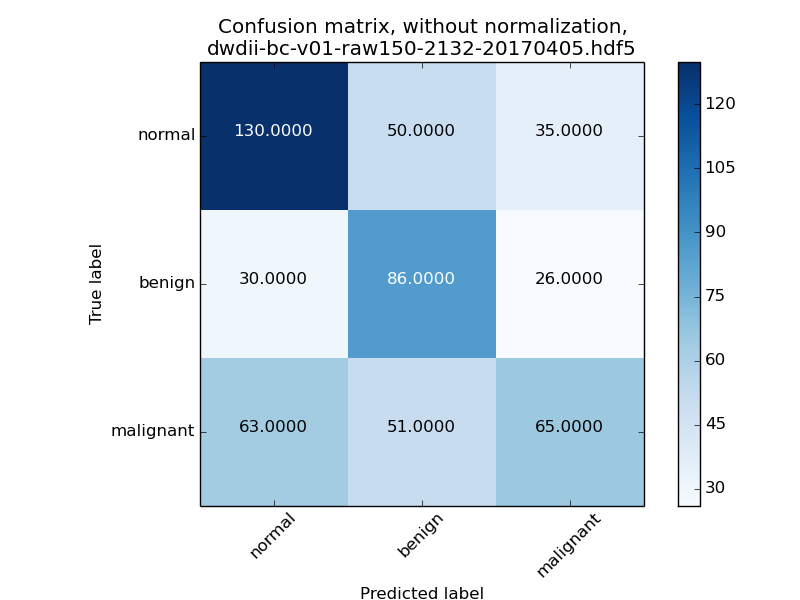

In [25]:
# Load the image we just saved
from IPython.display import Image
Image(filename=fileCfMatrix)

In [26]:
# Plot normalized confusion matrix
fileCfMatrixNorm = '../../figures/confusion_matrix_norm-' + weightsFileName + '.png'
plt.figure()
bc.plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix \n' + weightsFileName)
plt.savefig(fileCfMatrixNorm)

Normalized confusion matrix
[[ 0.6   0.23  0.16]
 [ 0.21  0.61  0.18]
 [ 0.35  0.28  0.36]]


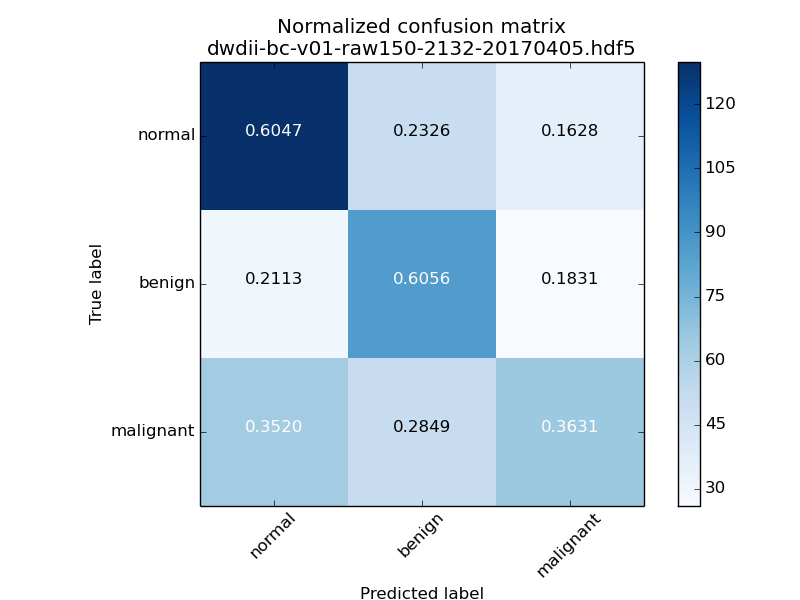

In [27]:
# Load the image we just saved
from IPython.display import Image
Image(filename=fileCfMatrixNorm)